In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\python311\lib\site-packages (from -r requirements.txt (line 1)) (1.5.2)




[notice] A new release of pip is available: 23.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Libraries

In [8]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras 
import keras.backend as K
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Lambda, Reshape, concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Reshape, concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout

Loading the MNIST Dataset

In [3]:
hidden_dim = 2
batch_size = 32
num_classes = 10 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# Redefine the noiser function and register it to ensure compatibility
@tf.keras.utils.register_keras_serializable()
def noiser(args):
    mean, log_var = args
    N = tf.random.normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return tf.exp(log_var / 2) * N + mean
# Define the custom loss function, required for loading the model
def vae_loss(y_true, y_pred, mean, log_var):
    y_true = tf.keras.backend.reshape(y_true, shape=(batch_size, 28*28))
    y_pred = tf.keras.backend.reshape(y_pred, shape=(batch_size, 28*28))
    reconstruction_loss = tf.math.reduce_sum(tf.math.square(y_true - y_pred), axis=-1)
    kl_loss = -0.5 * tf.math.reduce_sum(1 + log_var - tf.math.square(mean) - tf.math.exp(log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Load the saved model, including the custom loss function
cvae = load_model('cvae_model.keras', custom_objects={'noiser': noiser, 'vae_loss': vae_loss})
# Specify the number of additional images per class and number of classes
additional_samples_per_class = 7001
num_classes = 10  # For digits 0 to 9

# Function to generate additional synthetic images
def generate_dataset(cvae, decoder, latent_dim, additional_samples_per_class, num_classes, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    # Load existing labels or create a new labels CSV if it doesn't exist
    labels_csv_path = os.path.join(output_dir, "labels.csv")
    existing_labels = pd.read_csv(labels_csv_path, header=None, names=['img_path', 'label']) if os.path.exists(labels_csv_path) else pd.DataFrame(columns=['img_path', 'label'])
    
    for digit in range(num_classes):
        label = np.zeros((1, num_classes))
        label[0, digit] = 1
        
        # Check the current count and determine how many samples are needed
        existing_count = len(existing_labels[existing_labels['label'] == digit])
        new_samples_needed = additional_samples_per_class - existing_count
        
        if new_samples_needed <= 0:
            print(f"Digit {digit}: Already have enough samples. Skipping.")
            continue
        
        for i in range(existing_count, additional_samples_per_class):
            latent_sample = np.random.normal(size=(1, latent_dim))  # Sample from latent space
            generated_image = decoder.predict([latent_sample, label])  # Generate the image
            
            # Save generated image
            img_path = os.path.join(output_dir, f"digit_{digit}_sample_{i}.png")
            plt.imsave(img_path, generated_image.squeeze(), cmap='gray')
            
            # Append to the labels file
            with open(labels_csv_path, "a") as f:
                f.write(f"{img_path},{digit}\n")

# Specify the directory to save the generated dataset
output_dir = "synthetic_mnist_dataset"
generate_dataset(cvae, decoder=cvae.get_layer('decoder'), latent_dim=hidden_dim, 
                 additional_samples_per_class=additional_samples_per_class, 
                 num_classes=num_classes, output_dir=output_dir)

Digit 0: Already have enough samples. Skipping.
Digit 1: Already have enough samples. Skipping.
Digit 2: Already have enough samples. Skipping.
Digit 3: Already have enough samples. Skipping.
Digit 4: Already have enough samples. Skipping.
Digit 5: Already have enough samples. Skipping.
Digit 6: Already have enough samples. Skipping.
Digit 7: Already have enough samples. Skipping.
Digit 8: Already have enough samples. Skipping.
Digit 9: Already have enough samples. Skipping.


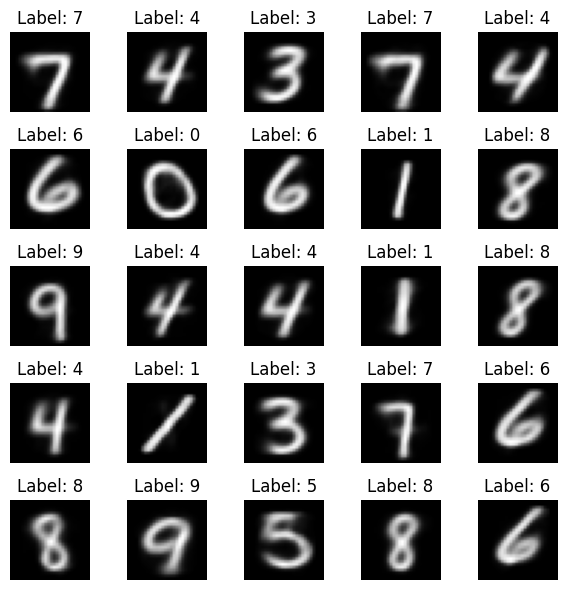

In [6]:
# Load the generated labels
data = pd.read_csv("synthetic_mnist_dataset/labels.csv")
data.columns = ['img_path', 'label']
sampled_data = data.sample(50)

fig, axes = plt.subplots(5, 5, figsize=(6, 6)) 
axes = axes.flatten()

for idx, (ax, (img_path, label)) in enumerate(zip(axes, sampled_data.values)):
    img = plt.imread(img_path)
    ax.imshow(img, cmap='gray')  
    ax.set_title(f"Label: {label}")
    ax.axis('off')  
plt.tight_layout()
plt.show()



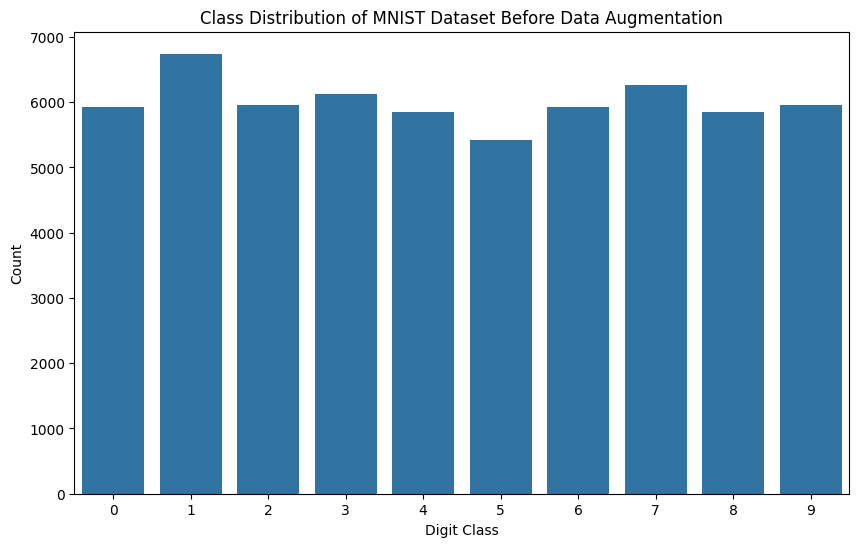

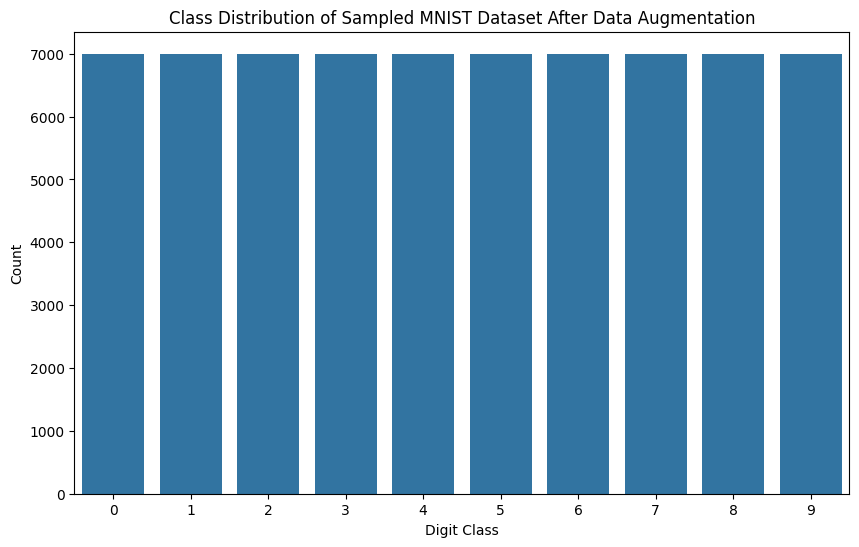

In [11]:
# Visualize the class distribution before data augmentation
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution of MNIST Dataset Before Data Augmentation')
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.show()

# Visualize the class distribution of the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x=data['label'])
plt.title('Class Distribution of Sampled MNIST Dataset After Data Augmentation')
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.show()